In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1);
from torch.utils import data


## Read data

In [3]:
from PIL import Image
from torch.utils import data
import os
from torch.utils.data import Subset, DataLoader
import random
random.seed(123)

In [4]:
class ExplosionDataset(data.Dataset):
    
    def __init__(self, path_to_data, seq_len):
        super(ExplosionDataset, self).__init__()
        self.path_to_data = path_to_data
        self.seq_len = seq_len
        
    def __len__(self):
        return len(os.listdir(self.path_to_data))
        
    def __getitem__(self, item):
        path_to_sequence = os.path.join(self.path_to_data, str(item))
        sequence_img = [None] * self.seq_len
        sequence_labels = [None] * self.seq_len 

        for img_path in os.listdir(path_to_sequence):
            im_index, label = img_path[:-4].split('frame')[1].split('_')
            im_index = int(im_index)
            label = int(label)
            full_path_to_img = os.path.join(path_to_sequence + "/", img_path)
            
            # load image and reshape to vector
            img = Image.open(full_path_to_img)
            img.load()
            img = np.asarray(img, dtype="float32") #IM_SIZE_1, IM_SIZE_2, CHANNELS                       
            sequence_img[im_index] = img
            sequence_labels[im_index] = label
            
        sequence_labels = np.asarray(sequence_labels)
        sequence_labels = torch.from_numpy(sequence_labels)
        sequence_img = np.asarray(sequence_img)
        sequence_img = torch.from_numpy(sequence_img).transpose(1, 3).transpose(2, 3) # seq_len, channels, im_size_1, im_size_2
        return sequence_img, sequence_labels

In [5]:
path_to_data = 'explosion_data/'
imgs_dataset = ExplosionDataset(path_to_data, seq_len=121)

In [6]:
def train_test_split(dataset, test_size=0.25, shuffle=True):
    _idx = np.arange(len(dataset))

    if shuffle:
        _train_idx = random.sample(list(_idx), int((1 - test_size)*len(dataset)))
    else:
        _train_idx = _idx[:-int(test_size*len(dataset))]    
        
    _test_idx = np.setdiff1d(_idx, _train_idx)
    
    train_ds = Subset(dataset, _train_idx)
    test_ds = Subset(dataset, _test_idx)

    return train_ds, test_ds

In [7]:
train_dataset, test_dataset = train_test_split(imgs_dataset)
train_dataset, valid_dataset = train_test_split(train_dataset, test_size=0.1)

In [8]:
BATCH_SIZE = 4
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Loss function

In [9]:
device = torch.device('cuda')

In [10]:
def loss_delay_detection_2(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0).to(device)
    loss = torch.arange(1, n + 1).to(device) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss


def loss_delay_detection(p_slice, w):
    n = p_slice.size(0) 
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    
    prod[1:] -= p_slice[:-1].to(device)
    cumprod = torch.cumprod(prod, dim=0).to(device)
    # TODO drop either n or w
    loss = (torch.arange(1, n + 1).to(device) * p_slice * cumprod 
            + (w + 1) * torch.prod(prod[1:]) * (1 - p_slice[-1]))
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice):
    length = len(p_slice)
    loss = 0
    
    start_ind = 0
    end_ind = 0
    
    while end_ind < length:
        start_ind = end_ind - 1
        if start_ind < 0:
            start_ind = 0
        end_ind = np.random.randint(start_ind, length + 2)
        if end_ind == start_ind:
            end_ind = end_ind + 1
        loss += 1 - loss_delay_detection_2(p_slice[start_ind: end_ind + 1])    
    #loss += 1 - loss_delay_detection_2(p_slice[start_ind: length])            
    loss = torch.sum(loss)
    return loss

In [11]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        loss = torch.zeros(labels.size(0))
        for i, label in enumerate(labels):
            ind = torch.where(label != label[0])[0]
            if ind.size()[0] == 0:
                loss[i] = loss_false_alarms(outputs[i, :])
            else:
                w = 16
                alpha = 0.5
                loss[i] = (alpha * loss_delay_detection(outputs[i, ind[0]:(ind[0] + w)], w) + 
                           (1 - alpha) * loss_false_alarms(outputs[i, :ind[0]]))
        loss = torch.mean(loss)
        return loss


## Model

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        print(x.shape)
        x = x.view(-1, 320)
        #x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        #x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [13]:
class Combine(nn.Module):
    def __init__(self):
        super(Combine, self).__init__()
        self.cnn = CNN()
        self.rnn = nn.LSTM(
            input_size=320, 
            hidden_size=64, 
            num_layers=1,
            batch_first=True)
        self.linear = nn.Linear(64,10)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, timesteps, -1)
        r_out, (h_n, h_c) = self.rnn(r_in)
        r_out2 = self.linear(r_out[:, -1, :])
        
        return F.log_softmax(r_out2, dim=1)

In [14]:
model = Combine()
model.to(device)

Combine(
  (cnn): CNN(
    (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (conv2_drop): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=320, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=10, bias=True)
  )
  (rnn): LSTM(320, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=10, bias=True)
)

In [15]:
loss_function = CustomLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
def train_model(model, loss_function, optimizer, train_loader, val_loader, batch_size, epochs=100, print_every=5):
    
    valid_loss_min = np.Inf

    loss_list = []
    acc_list = []
    overall_val_loss_list = []
    counter = 0
    
    model.train()

    out_list = []
    labels_list = []

    model.train()
    for i in range(epochs):
        # for inputs, labels in tqdm(train_loader):
        for inputs, labels in train_loader:
            if inputs.shape[0] < batch_size:
                break

            counter += 1
            inputs, labels = inputs.to(device), labels.to(device)  

            output = model(inputs)
            loss = loss_function(output.squeeze(), labels.float())
            
            loss_list += [loss.cpu().clone().detach()]
            accuracy = (output > 0.5).long() == labels
            acc_list += [accuracy.cpu().detach().float().mean()]
            out_list.append(output.cpu().detach().float())
            labels_list.append(labels.cpu().detach().float())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if counter%print_every == 0:
                val_losses = []
                val_outputs = []
                model.eval()
                for val_inputs, val_labels in val_loader:
                    if val_inputs.shape[0] < batch_size:
                        break
                        
                    val_out = model(val_inputs)
                    val_loss = loss_function(val_out.squeeze(), val_labels.float())
                    val_losses.append(val_loss.item())
                    val_outputs += [val_out.cpu().clone().detach()]

                val_outputs_one = torch.cat(val_outputs, 0)

                overall_val_loss_list.append(np.mean(val_losses))

                model.train()
                print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loпше ss: {:.6f}".format(np.mean(val_losses)))
    return model, (loss_list, acc_list, overall_val_loss_list)

In [17]:
model, (loss_list, acc_list, overall_val_loss_list) = train_model(model, loss_function, optimizer, 
                                                                  train_dataloader, val_dataloader, BATCH_SIZE, 1, 5)

torch.Size([484, 10, 119, 159])
torch.Size([484, 20, 58, 78])


RuntimeError: input.size(-1) must be equal to input_size. Expected 320, got 90480

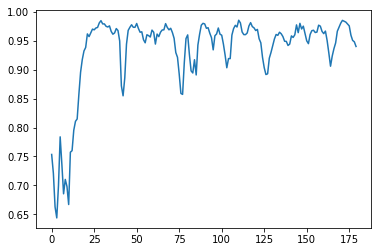

In [25]:
plt.plot(acc_list[::]);

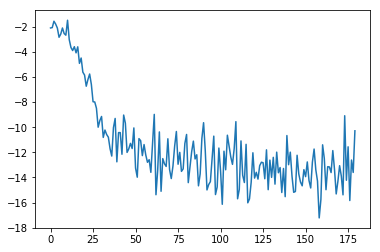

In [27]:
plt.plot(loss_list[::]);

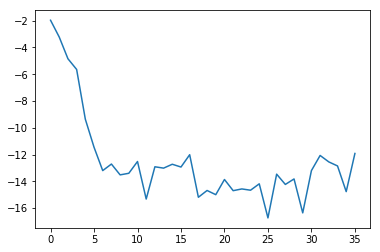

In [28]:
plt.plot(overall_val_loss_list);